<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/Tennis_Ball_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ballsemtpytt:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F85339%2F200998%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240227%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240227T164935Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7916fa30b5915ea06f2201894042868c5c112e3ed6d97671eafccaf78a3445f946a43c740d087e4155c6f7a842c8d1a8ed0a930d8f09f7bb66e25473ebade82ef1aba82c10f617c998ced82e9c77b28d12561a775b1ccdbccc854e21b587d80e48312a76d55cda159d482ab3ee772b5c6f1e576815393a8d56e818bc399ba39697b4e1f65f270dea6a3f501d86e7db1ed18c59a7a7cafa4ef1ce6d19a35edf96fbfd7cadef7bcc6737635fbb15415c95a434348bfffc028bd3df4c466259cebab8fd7ebab438609929c214232dc15ec15ce0dcfe6c35e88c8e7270d400dfb8aa3fc81c4837ed69af82bf3487f700b35e0addfb4c9ee2879795f5249a5053e00'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204163412 bytes downloaded
Downloaded and uncompressed: ballsemtpytt
Data source import complete.


# Tennis Ball Detection with Convolutional Neural Network

## Importing modules

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os

## Dataset

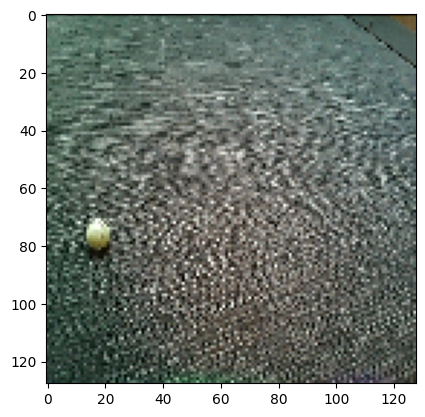

In [23]:
# Showing ball image
img = load_img('/kaggle/input/ballsemtpytt/test/balls/ball5.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

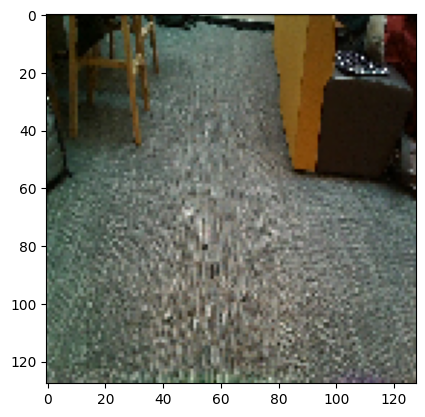

In [24]:
# Showing no ball image
img = load_img('/kaggle/input/ballsemtpytt/test/empty/empty6.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

In [25]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

In [26]:
# Loading images
x_train_balls = load_images_from_folder('/kaggle/input/ballsemtpytt/train/balls')
x_train_empty = load_images_from_folder('/kaggle/input/ballsemtpytt/train/empty')

y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )

x_test_balls = load_images_from_folder('/kaggle/input/ballsemtpytt/test/balls')
x_test_empty = load_images_from_folder('/kaggle/input/ballsemtpytt/test/empty')

y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

# Shuffling
randomize_train = np.arange(len(y_train))
np.random.shuffle(randomize_train)

randomize_test = np.arange(len(y_test))
np.random.shuffle(randomize_test)

x_train = x_train[randomize_train]/255
y_train = y_train[randomize_train]

x_test = x_test[randomize_test]/255
y_test = y_test[randomize_test]

## Model

In [27]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [28]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
26/26 [==============================] - 8s 293ms/step - loss: 0.6943 - accuracy: 0.5043 - val_loss: 0.6920 - val_accuracy: 0.6250
Epoch 2/50
26/26 [==============================] - 7s 280ms/step - loss: 0.6880 - accuracy: 0.5541 - val_loss: 0.6853 - val_accuracy: 0.6875
Epoch 3/50
26/26 [==============================] - 7s 252ms/step - loss: 0.6725 - accuracy: 0.5990 - val_loss: 0.6621 - val_accuracy: 0.7000
Epoch 4/50
26/26 [==============================] - 7s 276ms/step - loss: 0.6459 - accuracy: 0.6440 - val_loss: 0.6612 - val_accuracy: 0.5125
Epoch 5/50
26/26 [==============================] - 7s 260ms/step - loss: 0.6338 - accuracy: 0.6731 - val_loss: 0.6255 - val_accuracy: 0.6875
Epoch 6/50
26/26 [==============================] - 7s 271ms/step - loss: 0.6157 - accuracy: 0.7072 - val_loss: 0.5914 - val_accuracy: 0.7625
Epoch 7/50
26/26 [==============================] - 7s 270ms/step - loss: 0.6039 - accuracy: 0.7217 - val_loss: 0.5978 - val_accuracy: 0.6750
Epoch 

## History

In [29]:
history = pd.DataFrame(model.history.history)
model_loss = history.drop(columns=['accuracy', 'val_accuracy'])
model_accuracy = history.drop(columns=['loss', 'val_loss'])

<Axes: >

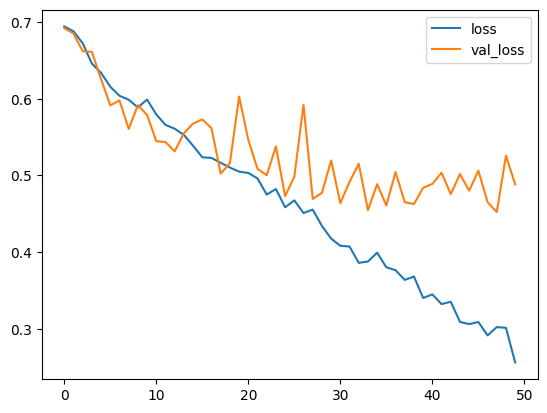

In [30]:
model_loss.plot()

<Axes: >

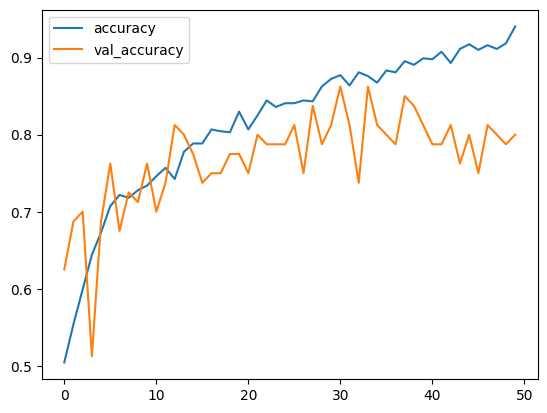

In [31]:
model_accuracy.plot()

## Model evaluation

In [32]:
predictions = np.rint(model.predict(x_test))

3/3 [==============================] - 0s 51ms/step


In [33]:
print( classification_report(y_test, predictions) )

              precision    recall  f1-score   support

         0.0       0.76      0.88      0.81        40
         1.0       0.85      0.72      0.78        40

    accuracy                           0.80        80
   macro avg       0.81      0.80      0.80        80
weighted avg       0.81      0.80      0.80        80



In [34]:
confusion_matrix(y_test, predictions)

array([[35,  5],
       [11, 29]])

Text(0.5, 1.0, 'prediction: [0.]')

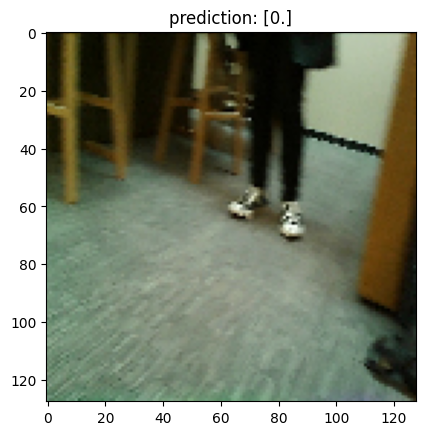

In [35]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [36]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load model

In [37]:
model = tf.keras.models.load_model('model.h5')